In [1]:
import pandas as pd
import re
import yaml
import sqlparse
import os
import pandas as pd
import requests
from IPython.display import display, Markdown


In [2]:
def add_repo_root_path():
    import os
    import sys
    repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
    if repo_root not in sys.path:
        sys.path.append(repo_root)
        
add_repo_root_path()
from src import generate_knowledge

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', 10) 

## Read dbs

In [4]:
local_dbt_repo = ''
online_dbt_repo = 'https://github.com/dbt-labs/jaffle-shop'

# Use local repo?
if False:
    repo_path = local_dbt_repo
else:
    repo_path = online_dbt_repo

is_online = generate_knowledge.is_online_repo(repo_path)
_, repo_name = generate_knowledge.extract_owner_and_repo(repo_path)
print(repo_name)

jaffle-shop


In [5]:
dbt_models_df = pd.read_csv('../data/dbt_models_' + repo_name + '.csv')
dbt_project_df = pd.read_csv('../data/dbt_project_' + repo_name + '.csv')
display(dbt_models_df.sample(3))
display(dbt_project_df.sample(3))

,path,name,extension,sql_code,config,materialized,is_snapshot,has_jinja_code,model_category,vertical,yml_code,tests,has_tests,sql_ids,has_select_all_in_last_select,has_group_by,primary_key,filters,is_filtered,macros,has_macros,parent_models,is_source_model,source,children_models,is_end_model,model_description,jinja_description
1,models/staging/stg_locations.sql,stg_locations.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,locations,"{'models': [{'name': 'stg_locations', 'descrip...","{'columns': {'location_id': ['not_null', 'uniq...",True,['location_id'],True,False,location_id,NaN,False,['dbt.date_trunc'],True,[],True,['ecom.raw_stores'],['locations'],False,"""Extracts a list of open store locations from ...",NaN
2,models/staging/stg_order_items.sql,stg_order_items.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,order_items,"{'models': [{'name': 'stg_order_items', 'descr...","{'columns': {'order_item_id': ['not_null', 'un...",True,"['product_id', 'order_item_id', 'order_id']",True,False,order_item_id,NaN,False,NaN,False,[],True,['ecom.raw_items'],['order_items'],False,"""Extracts individual food and drink items from...",NaN
4,models/staging/stg_products.sql,stg_products.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,products,"{'models': [{'name': 'stg_products', 'descript...","{'columns': {'product_id': ['not_null', 'uniqu...",True,['product_id'],True,False,product_id,NaN,False,['cents_to_dollars'],True,[],True,['ecom.raw_products'],"['order_items', 'products']",False,Retrieves product data from the 'raw_products'...,NaN


,path,name,extension,code,is_seed,is_macro,is_test,packages,description
0,Taskfile.yml,Taskfile.yml,.yml,version: '3'\nsilent: true\nvars:\n YEARS: 6\...,False,False,False,NaN,NaN
10,jaffle-data/raw_stores.csv,raw_stores.csv,.csv,id n...,False,False,False,NaN,NaN
11,jaffle-data/raw_supplies.csv,raw_supplies.csv,.csv,id name cost per...,False,False,False,NaN,NaN


In [6]:
def merge_dbt_models_and_project_dfs(dbt_models_df, dbt_project_df):
    dbt_models_df['knowledge_type'] = 'models'
    dbt_project_df['knowledge_type'] = 'project'

    dbt_models_df.rename(columns = {'sql_code':'code'}, inplace = True)

    all_columns = set(dbt_models_df.columns).union(set(dbt_project_df.columns))

    for col in all_columns:
        if col not in dbt_models_df:
            dbt_models_df[col] = None
        if col not in dbt_project_df:
            dbt_project_df[col] = None

    merged_df = pd.concat([dbt_models_df, dbt_project_df], ignore_index=True)
    columns_order = ['knowledge_type'] + [col for col in merged_df.columns if col != 'knowledge_type']
    return merged_df[columns_order]

In [7]:
dbt_repo_knowledge_df = merge_dbt_models_and_project_dfs(dbt_models_df, dbt_project_df)

## LangChain

#### Embeddings and Documents db

In [57]:
def combine_contextual_fields(row):
    combined = f"""        
        Code:
        {row['code'] if pd.notna(row['code']) else 'N/A'}

        Primary Key:
        {row['primary_key'] if pd.notna(row['primary_key']) else 'N/A'}

        IDS:
        {row['sql_ids'] if pd.notna(row['sql_ids']) else 'N/A'}

        Columns used to Filter the model throuhg JOINS, HAVING, WHERE...:
        {row['filters'] if pd.notna(row['filters']) else 'N/A'}

        Tests:
        {row['tests'] if pd.notna(row['tests']) else 'N/A'}

        YML Code:
        {row['yml_code'] if pd.notna(row['yml_code']) else 'N/A'}

        Description for project files:
        {row['description'] if pd.notna(row['description']) else 'N/A'}

        dbt Model description:
        {row['model_description'] if pd.notna(row['model_description']) else 'N/A'}

        Jinja inside the dbt model description:
        {row['jinja_description'] if pd.notna(row['jinja_description']) else 'N/A'}
    """
    return combined.strip()

dbt_repo_knowledge_df['contextual_info'] = dbt_repo_knowledge_df.apply(combine_contextual_fields, axis=1)

In [58]:
generate_knowledge.add_repo_root_path()
import openai_setup

OPENAI_API_KEY = openai_setup.conf['key']
OPENAI_PROJECT = openai_setup.conf['project']
OPENAI_ORGANIZATION = openai_setup.conf['organization']
DEFAULT_LLM_MODEL = "gpt-4o-mini"

In [59]:
from langchain.schema import Document

documents = dbt_repo_knowledge_df.apply(
    lambda row: Document(
        page_content=row["contextual_info"],
        metadata={
            "knowledge_type": row["knowledge_type"],
            "name": row["name"],
            "path": row["path"],
            "source": row["source"],
            "parents": row["parent_models"],
            "children": row["children_models"],
            "config": row["config"],
            "materialized": row["materialized"],
            "is_snapshot": row["is_snapshot"],
            "model_category": row["model_category"],
            "vertical": row["vertical"],
            "has_tests": row["has_tests"],
            "has_select_all_in_last_select": row["has_select_all_in_last_select"],
            "has_group_by": row["has_group_by"],
            "is_filtered": row["is_filtered"],
            "is_source_model": row["is_source_model"],
            "is_seed": row["is_seed"],
            "is_end_model": row["is_end_model"],
            "is_macro": row["is_macro"],
            "is_test": row["is_test"],
            "macros": row["macros"],
            "packages": row["packages"]
        }
    ), axis=1
).tolist()

SyntaxError: invalid syntax (2062221706.py, line 13)

In [56]:
dbt_repo_knowledge_df.sample(3)

,knowledge_type,path,name,extension,code,config,materialized,is_snapshot,has_jinja_code,model_category,vertical,yml_code,tests,has_tests,sql_ids,has_select_all_in_last_select,has_group_by,primary_key,filters,is_filtered,macros,has_macros,parent_models,is_source_model,source,children_models,is_end_model,model_description,jinja_description,is_macro,is_seed,packages,is_test,description,contextual_info
10,models,models/marts/orders.sql,orders.sql,.sql,WITH orders AS\n (SELECT *\n FROM {{ ref('s...,NaN,NaN,False,False,other,orders,"{'models': [{'name': 'orders', 'description': ...","{'columns': {'order_id': ['not_null', 'unique'...",True,"['order_item_id', 'customer_id', 'order_id']",True,True,order_id,['orders.order_id = order_items_summary.order_...,True,NaN,False,"['stg_orders', 'order_items']",False,NaN,['customers'],False,"""Aggregates order data from the 'stg_orders' a...",NaN,None,None,None,None,None,Code:\n WITH orders AS\n (SELECT *\n ...
25,project,jaffle-data/raw_supplies.csv,raw_supplies.csv,.csv,id name cost per...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,False,False,NaN,False,NaN,Code:\n id ...
13,models,models/staging/__sources.yml,__sources.yml,.yml,NaN,"\n{{\n config(\n materialized=""table...",table,False,False,sources,sources,"{'version': 2, 'sources': [{'name': 'ecom', 's...",NaN,False,NaN,False,False,NaN,NaN,False,NaN,False,[],False,NaN,[],True,"""Selects customer data from the 'raw_customers...",NaN,None,None,None,None,None,Code:\n N/A\n\n YML Code:\n ...


In [12]:
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS

embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)
vectorstore = FAISS.from_documents(documents, embeddings)

In [13]:
vectorstore

#### Test simple Retriever

In [14]:
from langchain.chains import RetrievalQA, LLMChain, SequentialChain
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.agents import initialize_agent, Tool
from langchain.schema.runnable import RunnableSequence

llm = ChatOpenAI(model=DEFAULT_LLM_MODEL, temperature=0.1, openai_api_key=OPENAI_API_KEY, openai_organization = OPENAI_ORGANIZATION)
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})

In [15]:
template = """
    You are a dbt expert. Based on the following context, answer the question concisely and accurately:
    {context}

    Question: {question}
"""
qa_prompt = PromptTemplate(template=template, input_variables=["context", "question"])

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": qa_prompt},
)

In [16]:
query = "Que modelos se veran fectados si cambio el nombre de customer_id en stg_customers"
result = qa_chain.invoke({"query": query})

print(result["result"])
print(result["source_documents"])

Si cambias el nombre de `customer_id` en el modelo `stg_customers`, los siguientes modelos se verán afectados:

1. **Modelo `customers`**: Este modelo hace referencia a `stg_customers` y utiliza `customer_id` en su lógica de unión y en la selección de columnas.

2. **Modelo `customer_orders_summary`**: Este modelo también utiliza `customer_id` para agrupar y resumir datos de pedidos.

Cualquier modelo que dependa de `stg_customers` y utilice `customer_id` necesitará ser actualizado para reflejar el nuevo nombre.
[Document(id='859c2154-a025-4c66-938e-b95d0111fa9b', metadata={'knowledge_type': 'models', 'name': 'stg_customers.sql', 'path': "['ecom.raw_customers']", 'source': 'models/staging/stg_customers.sql', 'parents': '[]', 'children': "['customers']"}, page_content='Code:\n        WITH SOURCE AS\n  (SELECT *\n   FROM {{ source(\'ecom\', \'raw_customers\') }}), renamed AS\n  (SELECT ----------  ids\n id AS customer_id, ---------- text\n name AS customer_name\n   FROM SOURCE)\nSELECT *

#### Agent test

In [17]:
# Retrieval Tool
retrieval_tool = Tool(
    name="Retrieve Info",
    func=lambda query: retriever.get_relevant_documents(query),
    description="Retrieve relevant context from the knowledge base.",
)

# Task Execution Prompt
task_prompt = PromptTemplate(
    template="""
        You are a dbt expert. Based on the context provided, perform the task below step-by-step:
        
        Task: {question}
        Context: {context}
    """,
    input_variables=["context", "question"],
)

# QA Chain for Task Execution
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": task_prompt},
)

# Task Execution Tool
task_tool = Tool(
    name="DBT Task Executor",
    func=lambda query: qa_chain.invoke({"query": query}),
    description="Execute dbt-related tasks like adding columns, creating models, or verifying dependencies.",
)

# Agent Configuration
tools = [retrieval_tool, task_tool]

agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent="zero-shot-react-description",
    verbose=True,
)

/var/folders/hv/ckh3m6gn1sd45q2qctrqcwzh0000gn/T/ipykernel_84249/586826549.py:38: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. See LangGraph documentation for more details: https://langchain-ai.github.io/langgraph/. Refer here for its pre-built ReAct agent: https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/
  agent = initialize_agent(


In [18]:
# Example Query
query = "Add a new column 'customer_age' to the 'stg_customers' model. The new column is available in the customer sources"

# Run the Agent
result = agent.run(query)
print("Agent Output:", result)



> Entering new AgentExecutor chain...


/var/folders/hv/ckh3m6gn1sd45q2qctrqcwzh0000gn/T/ipykernel_84249/795793740.py:5: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = agent.run(query)


I need to add a new column 'customer_age' to the 'stg_customers' model. This requires executing a dbt task to modify the model and include the new column from the customer sources. 

Action: DBT Task Executor  
Action Input: Add column 'customer_age' to 'stg_customers' model using customer sources.  
Observation: {'query': "Add column 'customer_age' to 'stg_customers' model using customer sources.", 'result': 'To add the `customer_age` column to the `stg_customers` model using customer sources, we will follow these steps:\n\n### Step 1: Update the SQL Code for `stg_customers`\n\n1. **Identify the Source for Customer Age**: We need to determine where the `customer_age` data is coming from. Assuming that the `raw_customers` source contains a `date_of_birth` or similar field, we will calculate the age based on that.\n\n2. **Modify the SQL Code**: We will add a calculation for `customer_age` in the SQL code of the `stg_customers` model.\n\nHere’s how the updated SQL code would look:\n\n```

#### Start agent chain

In [31]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

class Step:
    """Base class for a step in the processing pipeline."""
    def __init__(self, name):
        self.name = name

    def execute(self, input_data, context):
        raise NotImplementedError("Each step must implement the execute method.")


class EvaluationStep(Step):
    """Evaluate the user's request and decide the type of action needed."""
    def __init__(self, llm):
        super().__init__("Evaluation")
        self.llm = llm
        self.prompt_template = PromptTemplate(
            input_variables=["request"],
            template = (
                "Evaluate this request: {request}. Based on the evaluation, determine the required action: "
                "1) adding a field, 2) modifying an existing model, 3) creating a new model, or "
                "4) retrieving and returning specific information. "
                "Reflect on the request and provide a concise plan for the approach: "
                "- If the action involves adding a field: Identify where the field is currently available, if provided. "
                "Determine how to propagate the field through the necessary models or transformations to integrate it into the target model. "
                "Consider the impact on related models and dependencies. "
                "- If the action involves modifying an existing model: Identify the specific changes required. "
                "Assess how these changes affect the structure, relationships, and downstream dependencies of the model. "
                "- If the action involves retrieving or returning information: Identify the models containing the relevant data. "
                "Analyze how these models are related, and determine the queries or transformations needed to extract the requested information."
                "Return only useful information, no additional filler text or unnecessary explanations, get to the point."
            )
        )

    def execute(self, input_data, context):
        print(f"Step: {self.name} | Input: {input_data}")
        prompt = self.prompt_template.format(request=input_data)
        evaluation = self.llm.invoke(prompt)
        context["evaluation"] = evaluation
        print(f"Step: {self.name} | Output: {evaluation}")
        return evaluation


class ReflectionStep(Step):
    """Reflect on the user's request based on evaluation."""
    def __init__(self, llm):
        super().__init__("Reflection")
        self.llm = llm
        self.prompt_template = PromptTemplate(
            input_variables=["request", "evaluation"],
            template = (
                "Based on the evaluation: '{evaluation}', reflect on the request: {request}. "
                "Think about all the considerations and steps required to handle this request effectively. "
                "Your reflection should include the following actions: "
                "- Identify the target model or models: Analyze the dependency tree to locate the model where the change should occur. "
                "Understand its upstream sources (seeds, sources or base models) and downstream dependencies. "
                "- Check for field or model existence: Determine if the required field or base model already exists. "
                "If not, specify the steps to create it, including generating the necessary base table or model. "
                "- Documentation: Assess whether the target model and its sources are documented. "
                "If documentation is missing or outdated, note whether it needs to be created or updated. "
                "- Unique keys and IDs: Examine the available unique keys and identifiers in the initial, intermediate, and final models. "
                "Decide how these can be used to integrate the field or establish relationships between models. "
                "- Evaluate performance and design: Review the data pipeline from start to finish. "
                "Decide where the change or addition would be most optimal in terms of performance, data modeling, and maintainability. "
                "- Project state and impact: Consider the current state of the dbt project and how the changes might affect the broader model chain. "
                "- Macros and seeds: Check if relevant macros or seed data exist that can help transform or derive the required field or model. "
                "- Tests: Identify existing tests for the field or model and determine whether new tests need to be added or adjusted to validate the changes. "
                "- dbt project configuration: Review the general configuration (e.g., variables, environments, conventions) in the dbt_project.yml file "
                "to ensure the changes align with project standards and won't disrupt the schema. "
                "- Code generation:  fragments of SQL logic needed, including CTEs or columns. "
                "Evaluate whether an intermediate model is necessary or if the logic can be handled within the existing pipeline. "
                "- Documentation generation: Specify the documentation needed for any fields, models, or logic added or updated as part of this request. "
                "Provide a concise summary of the high-level plan based on your analysis."
                "No extra checks or steps that are not on this list, select only the needed actions for the request."
                "Return only useful information, no additional filler text or unnecessary explanations, get to the point."
            )
        )

    def execute(self, input_data, context):
        print(f"Step: {self.name} | Input: {input_data}")
        evaluation = context.get("evaluation", "")
        prompt = self.prompt_template.format(request=input_data, evaluation=evaluation)
        reflection = self.llm.invoke(prompt)
        context["reflection"] = reflection
        print(f"Step: {self.name} | Output: {reflection}")
        return reflection


class PlanStep(Step):
    """Plan the steps needed based on reflection and retrieved context."""
    def __init__(self, llm, retriever):
        super().__init__("Plan")
        self.llm = llm
        self.retriever = retriever
        self.prompt_template = PromptTemplate(
            input_variables=["reflection", "retrieved_context"],
            template = (
                "Based on this reflection: {reflection} and the retrieved information: {retrieved_context}, "
                "create a detailed step-by-step plan of the changes required in the existing models or files within the repository "
                "to implement the requested change accurately. "
                "Ensure that you only refer to files, models, or fields that are explicitly mentioned in the retrieved information. "
                "Do not invent new models, fields, or dependencies. Focus on: "
                "- Identifying the exact files or models that need modifications, based on the retrieved context. "
                "- Specifying what changes should be made, such as adding fields, updating logic, or modifying relationships. "
                "- Highlighting any dependencies between models or files and describing how these should be handled. "
                "- Extract children or parent models affected."
                "- If code fragments are provided in the retrieved context, incorporate them where applicable and explain their role. "
                "- If no specific code or file is mentioned in the retrieved information, state that no changes should be made to existing files. "
                "- Ensure the changes align with the dbt project's standards, such as conventions in `dbt_project.yml`, and do not introduce schema-breaking modifications. "
                "No extra checks or steps that are not on this list."
                "Provide precise and actionable recommendations, avoiding any assumptions beyond the retrieved information."
                "Return only useful information, no additional filler text or unnecessary explanations, get to the point."
            )
        )

    def execute(self, input_data, context):
        print(f"Step: {self.name} | Input: {input_data}")
        reflection = context.get("reflection", "")

        # Recuperar documentos con el método adecuado
        documents = self.retriever.invoke(input_data)

        # Extraer el contenido textual de los documentos
        retrieved_context = "\n".join([doc.page_content for doc in documents if hasattr(doc, 'page_content')])
        context["documents"] = documents
        print(f"Step: {self.name} | Retrieved Context: {retrieved_context}")

        # Generar el prompt con la reflexión y el contexto recuperado
        prompt = self.prompt_template.format(reflection=reflection, retrieved_context=retrieved_context)

        # Convertimos el prompt a cadena y lo pasamos a invoke
        plan = self.llm.invoke(prompt)
        context["plan"] = plan
        print(f"Step: {self.name} | Output: {plan}")
        return plan


class ChatPipeline:
    """Manages the pipeline of steps."""
    def __init__(self, steps):
        self.steps = steps

    def execute(self, input_data):
        context = {}
        for step in self.steps:
            print(f"\nExecuting step: {step.name}")
            result = step.execute(input_data, context)
            print(f"Finished step: {step.name} | Result: {result}\n")
        return context


def main(user_input, llm, retriever):
    # Define the steps
    steps = [
        EvaluationStep(llm),
        ReflectionStep(llm),
        PlanStep(llm, retriever),
    ]

    # Create the pipeline
    pipeline = ChatPipeline(steps)

    context = pipeline.execute(user_input)
    print("Context at the end of pipeline:", context)

    return context

In [36]:
user_input = "si cambio algo en el modelo de salida orders, cuales son todos sus parent models que tendria que consultar"
llm_results = main(user_input, llm, retriever)


Executing step: Evaluation
Step: Evaluation | Input: si cambio algo en el modelo de salida orders, cuales son todos sus parent models que tendria que consultar
Step: Evaluation | Output: content="To evaluate the request regarding changes to the `orders` model, follow these steps:\n\n1. **Identify Parent Models**: Determine all parent models related to `orders`. This includes any models that directly or indirectly influence the `orders` model.\n\n2. **Determine Action**: Based on the request, assess whether the change involves:\n   - **Adding a Field**: If so, identify the field's current availability and how to propagate it through the necessary models.\n   - **Modifying an Existing Model**: Identify specific changes needed and assess their impact on structure and dependencies.\n   - **Creating a New Model**: If the change requires a new model, outline its purpose and relationships.\n   - **Retrieving Information**: Identify relevant models and determine the necessary queries or trans

In [37]:
Markdown(llm_results['plan'].content)

### Step-by-Step Plan for Changes Required

1. **Identify Models for Modification**:
   - **Models to Modify**:
     - `stg_orders`
     - `orders`
     - `order_items`
     - `customers`
     - `customer_orders_summary`

2. **Changes to `stg_orders` Model**:
   - **Field Updates**:
     - Ensure that the fields `order_id`, `customer_id`, `ordered_at`, `store_id`, `subtotal`, `tax_paid`, and `order_total` are correctly defined and exist in the model.
   - **Logic**:
     - Confirm that the logic for converting cents to dollars is correctly implemented using the `cents_to_dollars` macro.

3. **Changes to `orders` Model**:
   - **Field Updates**:
     - Ensure that the fields `order_id`, `customer_id`, `ordered_at`, `order_total`, `order_cost`, `is_food_order`, and `is_drink_order` are present and correctly defined.
   - **Logic**:
     - Validate the logic that calculates `order_items_subtotal` and ensure it matches the `subtotal` field.
     - Ensure that the boolean fields `is_food_order` and `is_drink_order` are computed correctly based on the `order_items_summary`.

4. **Changes to `order_items` Model**:
   - **Field Updates**:
     - Ensure that the fields `order_id`, `sku`, and `supply_cost` are present and correctly defined.
   - **Logic**:
     - Confirm that the aggregation logic for `order_items_summary` is correctly summing the `supply_cost` and counting the items.

5. **Changes to `customers` Model**:
   - **Field Updates**:
     - Ensure that the `customer_id` field is present and correctly defined.
   - **Logic**:
     - Validate the logic that determines `customer_type` based on the count of orders.

6. **Changes to `customer_orders_summary` Model**:
   - **Field Updates**:
     - Ensure that the fields `customer_id`, `count_lifetime_orders`, `first_ordered_at`, `last_ordered_at`, `lifetime_spend_pretax`, `lifetime_tax_paid`, and `lifetime_spend` are present and correctly defined.
   - **Logic**:
     - Confirm that the aggregation logic is correctly summarizing the lifetime metrics for each customer.

7. **Dependencies**:
   - **Parent Models**:
     - Ensure that any changes in `stg_orders` and `order_items` are reflected in the `orders` model.
   - **Child Models**:
     - Ensure that changes in the `orders` model are correctly propagated to `customer_orders_summary` and any other dependent models.

8. **Testing**:
   - **Existing Tests**:
     - Review existing tests in the `orders` and `customers` models to ensure they validate the new logic.
   - **New Tests**:
     - If any new fields or logic are introduced, create corresponding tests to validate their correctness.

9. **Documentation**:
   - Update the YML files for each model to reflect any changes in fields or logic.
   - Ensure that the documentation for the `orders`, `customers`, and `customer_orders_summary` models is comprehensive and up-to-date.

10. **dbt Project Configuration**:
    - Review the `dbt_project.yml` to ensure that all changes align with project standards and do not introduce schema-breaking modifications.

### Summary of Changes
- Modify `stg_orders`, `orders`, `order_items`, `customers`, and `customer_orders_summary` models as specified.
- Ensure all dependencies are respected and that documentation is updated accordingly.
- Validate existing tests and add new tests as necessary.

In [52]:
dbt_repo_knowledge_df

,knowledge_type,path,name,extension,code,config,materialized,is_snapshot,has_jinja_code,model_category,vertical,yml_code,tests,has_tests,sql_ids,has_select_all_in_last_select,has_group_by,primary_key,filters,is_filtered,macros,has_macros,parent_models,is_source_model,source,children_models,is_end_model,model_description,jinja_description,is_macro,is_seed,packages,is_test,description,contextual_info
0,models,models/staging/stg_customers.sql,stg_customers.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,customers,"{'models': [{'name': 'stg_customers', 'descrip...","{'columns': {'customer_id': ['not_null', 'uniq...",True,['customer_id'],True,False,customer_id,NaN,False,NaN,False,[],True,['ecom.raw_customers'],['customers'],False,"""Extracts customer data from the 'raw_customer...",NaN,None,None,None,None,None,Code:\n WITH SOURCE AS\n (SELECT *\n ...
1,models,models/staging/stg_locations.sql,stg_locations.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,locations,"{'models': [{'name': 'stg_locations', 'descrip...","{'columns': {'location_id': ['not_null', 'uniq...",True,['location_id'],True,False,location_id,NaN,False,['dbt.date_trunc'],True,[],True,['ecom.raw_stores'],['locations'],False,"""Extracts a list of open store locations from ...",NaN,None,None,None,None,None,Code:\n WITH SOURCE AS\n (SELECT *\n ...
2,models,models/staging/stg_order_items.sql,stg_order_items.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,order_items,"{'models': [{'name': 'stg_order_items', 'descr...","{'columns': {'order_item_id': ['not_null', 'un...",True,"['product_id', 'order_item_id', 'order_id']",True,False,order_item_id,NaN,False,NaN,False,[],True,['ecom.raw_items'],['order_items'],False,"""Extracts individual food and drink items from...",NaN,None,None,None,None,None,Code:\n WITH SOURCE AS\n (SELECT *\n ...
3,models,models/staging/stg_orders.sql,stg_orders.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,orders,"{'models': [{'name': 'stg_orders', 'descriptio...","{'columns': {'order_id': ['not_null', 'unique'...",True,"['location_id', 'store_id', 'customer_id', 'or...",True,False,order_id,NaN,False,"['cents_to_dollars', 'dbt.date_trunc']",True,[],True,['ecom.raw_orders'],"['order_items', 'orders']",False,Retrieves order data from the 'ecom.raw_orders...,NaN,None,None,None,None,None,Code:\n WITH SOURCE AS\n (SELECT *\n ...
4,models,models/staging/stg_products.sql,stg_products.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,products,"{'models': [{'name': 'stg_products', 'descript...","{'columns': {'product_id': ['not_null', 'uniqu...",True,['product_id'],True,False,product_id,NaN,False,['cents_to_dollars'],True,[],True,['ecom.raw_products'],"['order_items', 'products']",False,Retrieves product data from the 'raw_products'...,NaN,None,None,None,None,None,Code:\n WITH SOURCE AS\n (SELECT *\n ...
5,models,models/staging/stg_supplies.sql,stg_supplies.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,supplies,"{'models': [{'name': 'stg_supplies', 'descript...","{'columns': {'supply_uuid': ['not_null', 'uniq...",True,"['product_id', 'supply_id']",True,False,supply_uuid,NaN,False,"['cents_to_dollars', 'dbt_utils.generate_surro...",True,[],True,['ecom.raw_supplies'],"['order_items', 'supplies']",False,Retrieves supply expense data from the 'raw_su...,NaN,None,None,None,None,None,Code:\n WITH SOURCE AS\n (SELECT *\n ...
6,models,models/marts/customers.sql,customers.sql,.sql,WITH customers AS\n (SELECT *\n FROM {{ ref...,NaN,NaN,False,False,other,customers,"{'models': [{'name': 'customers', 'description...","{'columns': {'customer_id': ['not_null', 'uniq...",True,"['customer_id', 'order_id']",True,True,customer_id,['customers.customer_id = customer_orders_summ...,True,NaN,False,"['stg_customers', 'orders']",False,NaN,[],True,"""Aggregates customer data from the 'stg_custom..

In [53]:
lineage_df = dbt_repo_knowledge_df[(dbt_repo_knowledge_df['knowledge_type'] == 'models') & (dbt_repo_knowledge_df['extension'] == '.sql')][['name','parent_models','children_models','source']]
lineage_df['model_name'] = lineage_df['name'].apply(lambda x: x[:-4])
lineage_df = lineage_df.drop(columns=['name'])[['model_name','source','parent_models','children_models']]
lineage_df

,model_name,source,parent_models,children_models
0,stg_customers,['ecom.raw_customers'],[],['customers']
1,stg_locations,['ecom.raw_stores'],[],['locations']
2,stg_order_items,['ecom.raw_items'],[],['order_items']
3,stg_orders,['ecom.raw_orders'],[],"['order_items', 'orders']"
4,stg_products,['ecom.raw_products'],[],"['order_items', 'products']"
5,stg_supplies,['ecom.raw_supplies'],[],"['order_items', 'supplies']"
6,customers,NaN,"['stg_customers', 'orders']",[]
7,locations,NaN,['stg_locations'],[]
8,metricflow_time_spine,NaN,[],[]
9,order_items,NaN,"['stg_order_items', 'stg_orders', 'stg_product...",['orders']


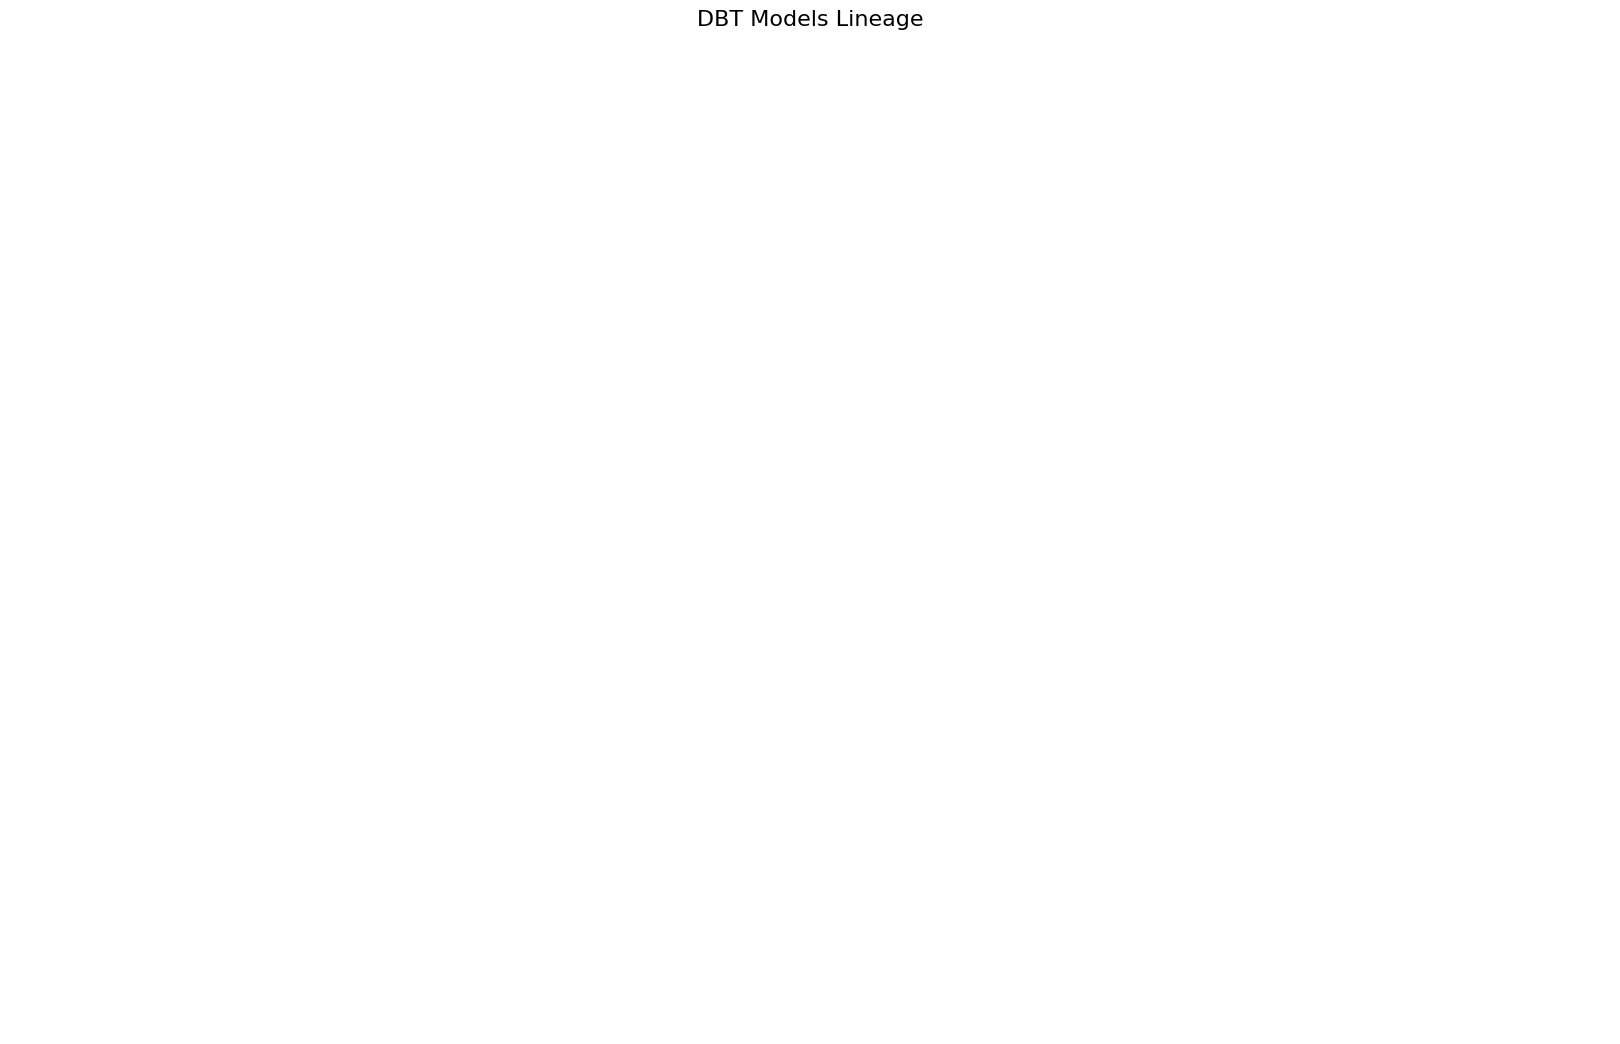

In [55]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Asegurar listas vacías en NaN
lineage_df["source"] = lineage_df["source"].apply(lambda x: x if isinstance(x, list) else [])
lineage_df["parent_models"] = lineage_df["parent_models"].apply(lambda x: x if isinstance(x, list) else [])
lineage_df["children_models"] = lineage_df["children_models"].apply(lambda x: x if isinstance(x, list) else [])

# Paso 1: Crear el grafo dirigido
G = nx.DiGraph()

# Agregar fuentes como nodos únicos
all_sources = lineage_df["source"].sum()  # Flatten y eliminar NaN
unique_sources = list(set(all_sources))
G.add_nodes_from(unique_sources, layer=0)

# Paso 2: Agregar nodos y aristas para modelos con source pero sin parent models
for _, row in lineage_df.iterrows():
    if row["source"] and not row["parent_models"]:
        G.add_node(row["model_name"], layer=1)
        for source in row["source"]:
            G.add_edge(source, row["model_name"])

# Paso 3: Agregar nodos y aristas para modelos con source y parent models
for _, row in lineage_df.iterrows():
    if row["source"] and row["parent_models"]:
        G.add_node(row["model_name"], layer=2)
        for source in row["source"]:
            G.add_edge(source, row["model_name"])
        for parent in row["parent_models"]:
            G.add_edge(parent, row["model_name"])

# Paso 4: Agregar nodos y aristas para modelos sin source pero con parent y children models
for _, row in lineage_df.iterrows():
    if not row["source"] and row["parent_models"] and row["children_models"]:
        G.add_node(row["model_name"], layer=3)
        for parent in row["parent_models"]:
            G.add_edge(parent, row["model_name"])
        for child in row["children_models"]:
            G.add_edge(row["model_name"], child)

# Paso 5: Agregar nodos y aristas para modelos sin children models
for _, row in lineage_df.iterrows():
    if not row["children_models"] and row["parent_models"]:
        G.add_node(row["model_name"], layer=4)
        for parent in row["parent_models"]:
            G.add_edge(parent, row["model_name"])

# Colorear nodos por capa
layer_colors = {
    0: "lightgreen",
    1: "lightblue",
    2: "orange",
    3: "pink",
    4: "gray"
}
node_colors = [layer_colors[G.nodes[n]["layer"]] for n in G.nodes]

# Dibujar el grafo
plt.figure(figsize=(16, 10))
pos = nx.multipartite_layout(G, subset_key="layer")  # Layout por capas
nx.draw(
    G, pos, with_labels=True, node_size=3000, node_color=node_colors,
    font_size=10, font_weight="bold", arrowsize=20
)
plt.title("DBT Models Lineage", fontsize=16)
plt.show()
